In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
from IPython.display import clear_output

In [2]:
model = tf.keras.models.load_model("signs_model.h5")

In [3]:
lossFunct = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

## Load the image

In [4]:
image = cv2.imread("stop.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64,64))
image = np.expand_dims(image, axis=0)
image = tf.constant(image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(image), trainable=True)
real_class = 14
target_class = 12


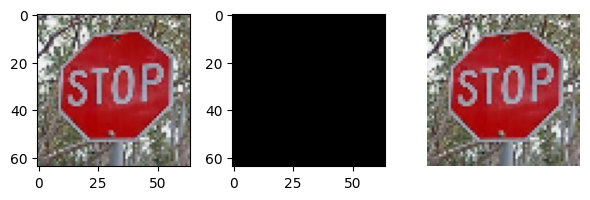

In [5]:
adv_image = tf.clip_by_value(image + delta, 0, 255)
plt.figure(figsize=(6, 6))
plt.subplot(1, 3, 1)
plt.imshow(image[0].numpy().astype(np.uint8))
plt.subplot(1, 3, 2)
plt.imshow(delta[0].numpy().astype(np.uint8))
plt.subplot(1, 3, 3)
plt.imshow(adv_image[0].numpy().astype(np.uint8))
plt.axis("off")
plt.tight_layout()
plt.show()  

## Load labels

In [6]:
import pandas as pd
classes = pd.read_csv('signs_labels.csv')
for i in range(20):
    print(f'Label {i}: {classes.loc[i][1]}')

Label 0: Speed limit (20km/h)
Label 1: Speed limit (30km/h)
Label 2: Speed limit (50km/h)
Label 3: Speed limit (60km/h)
Label 4: Speed limit (70km/h)
Label 5: Speed limit (80km/h)
Label 6: End of speed limit (80km/h)
Label 7: Speed limit (100km/h)
Label 8: Speed limit (120km/h)
Label 9: No passing
Label 10: No passing for vehicles over 3.5 metric tons
Label 11: Right-of-way at the next intersection
Label 12: Priority road
Label 13: Yield
Label 14: Stop
Label 15: No vehicles
Label 16: Vehicles over 3.5 metric tons prohibited
Label 17: No entry
Label 18: General caution
Label 19: Dangerous curve to the left


C:\Users\szsze\AppData\Local\Temp\ipykernel_17836\1427027777.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Label {i}: {classes.loc[i][1]}')


## Predict class for image

In [7]:
def do_step():
    with tf.GradientTape() as tape:
        tape.watch(delta)
        adv_image = tf.clip_by_value(image + delta, 0, 255)
        prediction = model(adv_image, training=False)
        original_loss = lossFunct(tf.convert_to_tensor([real_class]), prediction)
        target_loss = lossFunct(tf.convert_to_tensor([target_class]), prediction)
        loss = target_loss - original_loss

    gradients = tape.gradient(loss, delta)
    optimizer.apply_gradients([(gradients, delta)])
    clipped_delta = tf.clip_by_value(delta, clip_value_min=-0.01, clip_value_max=0.01)
    delta.assign_add(clipped_delta)

    return loss, prediction

In [8]:
def get_predicted_class(prediction):
    return classes.loc[np.argmax(prediction.numpy(), axis=1)[0]][1]

In [9]:
def show_step(step, prediction, loss):
    clear_output(wait=True)

    predicted_class = get_predicted_class(prediction)
    print(f"Step: {step}, Prediction: {predicted_class}, Loss: {loss.numpy()}, Target Class Probability: {prediction[0][target_class].numpy()}")
    adv_image = tf.clip_by_value(image + delta, 0, 255)
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].numpy().astype(np.uint8))
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(delta[0].numpy().astype(np.uint8))
    plt.axis("off")
    plt.title("Perturbation (Delta)")

    plt.subplot(1, 3, 3)
    plt.imshow(adv_image[0].numpy().astype(np.uint8))
    plt.axis("off")
    plt.title("Adversarial Image")

    plt.tight_layout()
    plt.show()   

In [10]:
def learn(stepes=100):
    for step in range(stepes):
        loss, prediction = do_step()
        predicted_class = get_predicted_class(prediction)

        if step % 10 == 0:
            show_step(step, prediction, loss)

        if np.argmax(prediction.numpy(), axis=1)[0] == target_class:
            show_step(step, prediction, loss)
            print(f"Target class {target_class} reached at step {step}.")
            break

In [11]:
prediction = get_predicted_class(model(image))
print(f"Prediction: {prediction}, Real class: {real_class}")

Prediction: Stop, Real class: 14


C:\Users\szsze\AppData\Local\Temp\ipykernel_17836\498547288.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return classes.loc[np.argmax(prediction.numpy(), axis=1)[0]][1]


Step: 117, Prediction: Priority road, Loss: -44.83257293701172, Target Class Probability: 0.5712695121765137


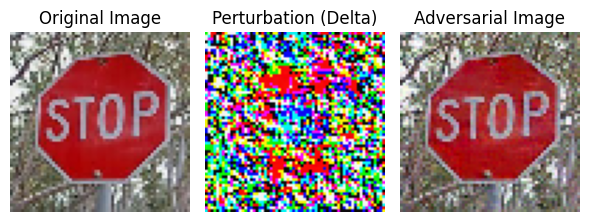

Target class 12 reached at step 117.


In [12]:
learn(1000)